# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 60

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.03 s, sys: 147 ms, total: 2.17 s
Wall time: 2.17 s


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.178286075592041


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 5.64 ms, sys: 0 ns, total: 5.64 ms
Wall time: 5.56 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 4.61 ms, sys: 0 ns, total: 4.61 ms
Wall time: 4.59 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT','RIBO'], percent_top=None, log1p=False, inplace=True)

CPU times: user 1.31 s, sys: 77.4 ms, total: 1.38 s
Wall time: 1.38 s


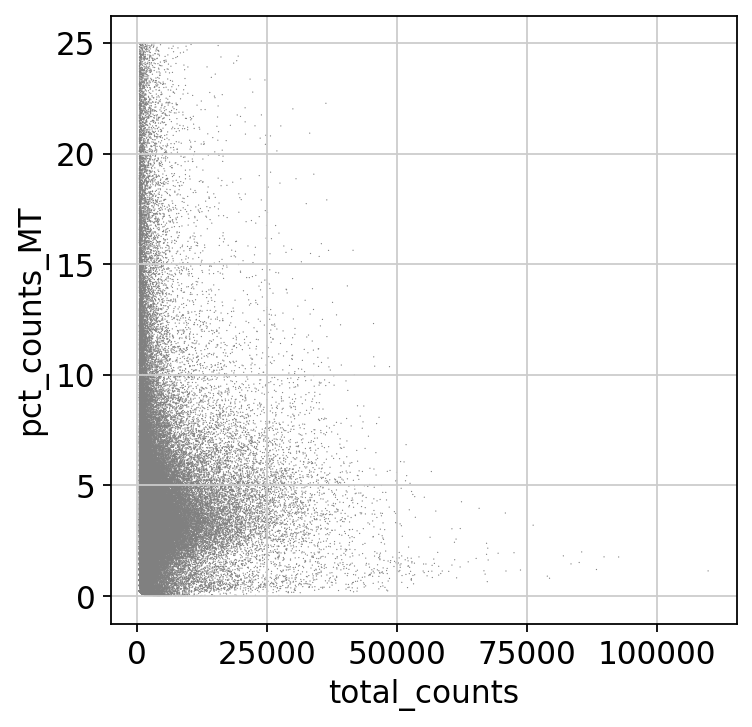

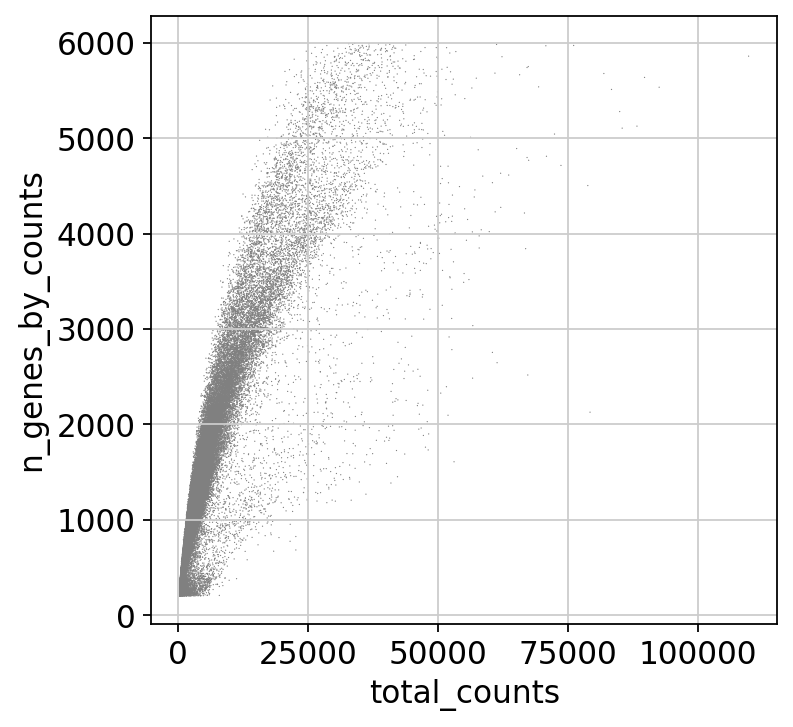

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

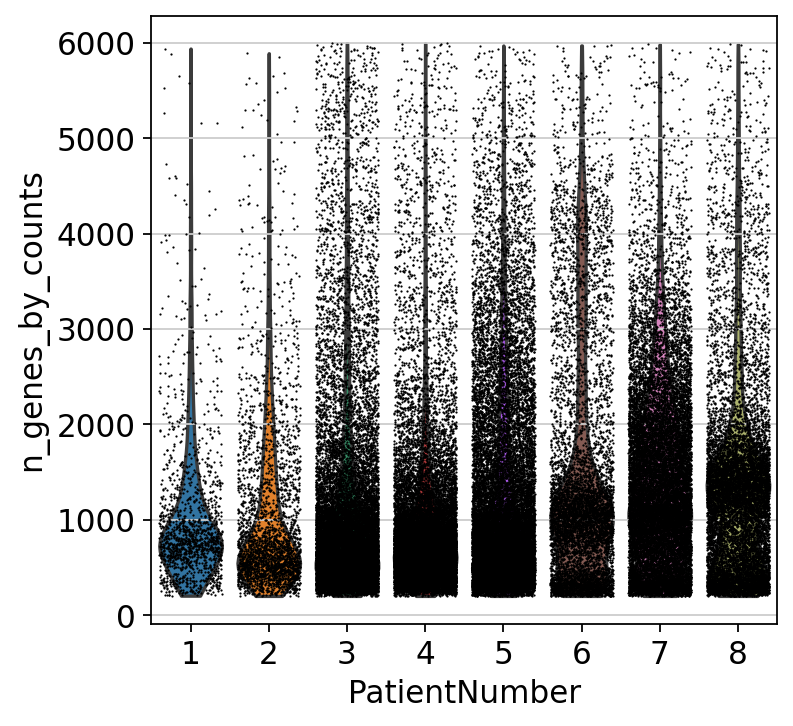

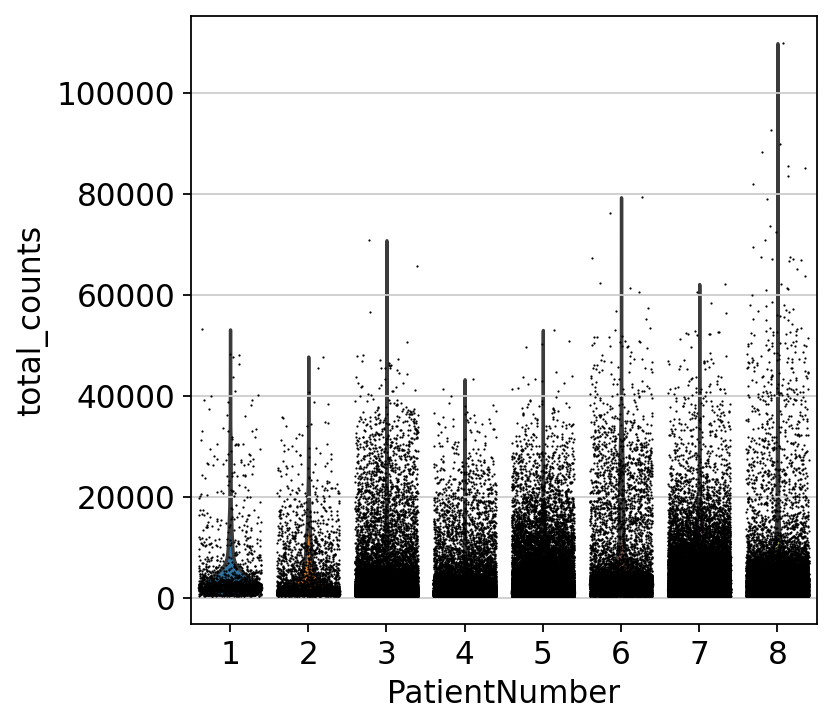

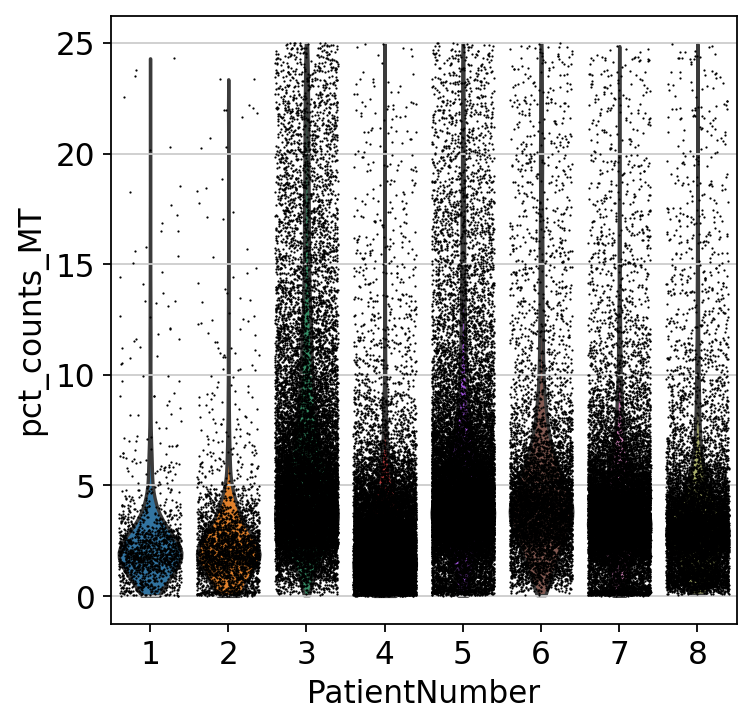

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

The size of our count matrix is now reduced.

In [11]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :].copy()
adata = adata[adata.obs.pct_counts_MT < 20, :].copy()

CPU times: user 192 ms, sys: 176 ms, total: 367 ms
Wall time: 367 ms


In [12]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

CPU times: user 553 ms, sys: 170 ms, total: 723 ms
Wall time: 722 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [14]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 239 ms, sys: 23.1 ms, total: 262 ms
Wall time: 262 ms


Next, we log transform the count matrix.

In [15]:
%%time
sc.pp.log1p(adata)

CPU times: user 804 ms, sys: 2.79 ms, total: 807 ms
Wall time: 806 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [16]:
%%time
sc.pp.highly_variable_genes(adata,flavor = "cell_ranger",n_top_genes=5000)

CPU times: user 504 ms, sys: 38.5 ms, total: 543 ms
Wall time: 555 ms


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [17]:
%%time
adata.raw = adata

CPU times: user 59.7 ms, sys: 27.9 ms, total: 87.6 ms
Wall time: 86.7 ms


Restrict adata to only the highly variable genes

In [18]:
%%time
adata = adata[:, adata.var.highly_variable].copy()

CPU times: user 313 ms, sys: 113 ms, total: 426 ms
Wall time: 426 ms


In [19]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [20]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 36.4 s, sys: 15.4 s, total: 51.8 s
Wall time: 57.1 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [21]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.22 s, sys: 151 ms, total: 1.37 s
Wall time: 1.37 s


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [22]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 64.84291291236877


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [23]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 15min 4s, sys: 38.9 s, total: 15min 43s
Wall time: 31 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

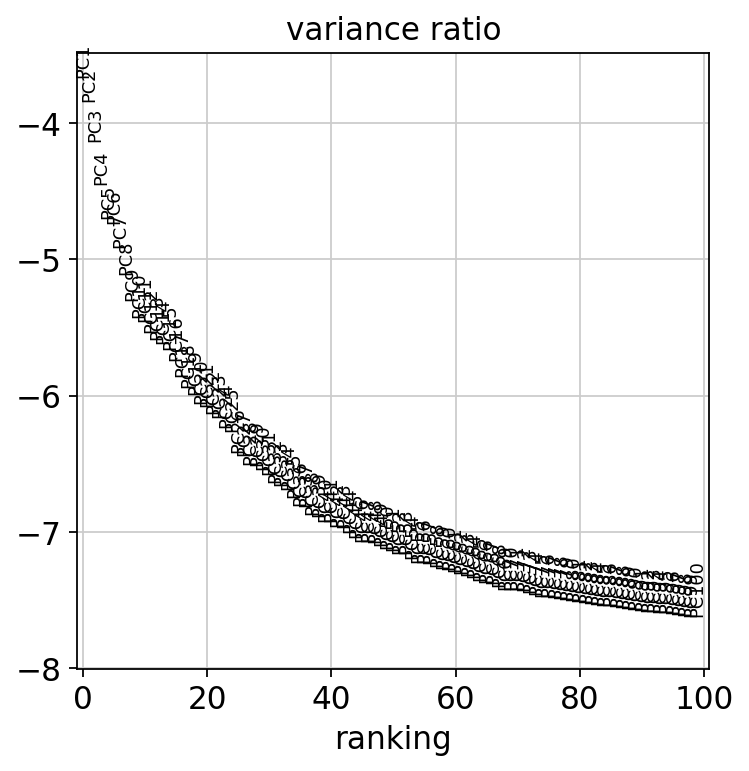

In [24]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [25]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 25 s, sys: 5.62 s, total: 30.7 s
Wall time: 13.5 s


In [26]:
%%time
sc.tl.umap(adata)

CPU times: user 2min 50s, sys: 59.5 s, total: 3min 49s
Wall time: 29.3 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [27]:
%%time
sc.tl.louvain(adata)

CPU times: user 14.7 s, sys: 43.4 ms, total: 14.7 s
Wall time: 14.7 s


In [28]:
%%time
sc.tl.leiden(adata)

CPU times: user 10.7 s, sys: 104 ms, total: 10.8 s
Wall time: 10.8 s


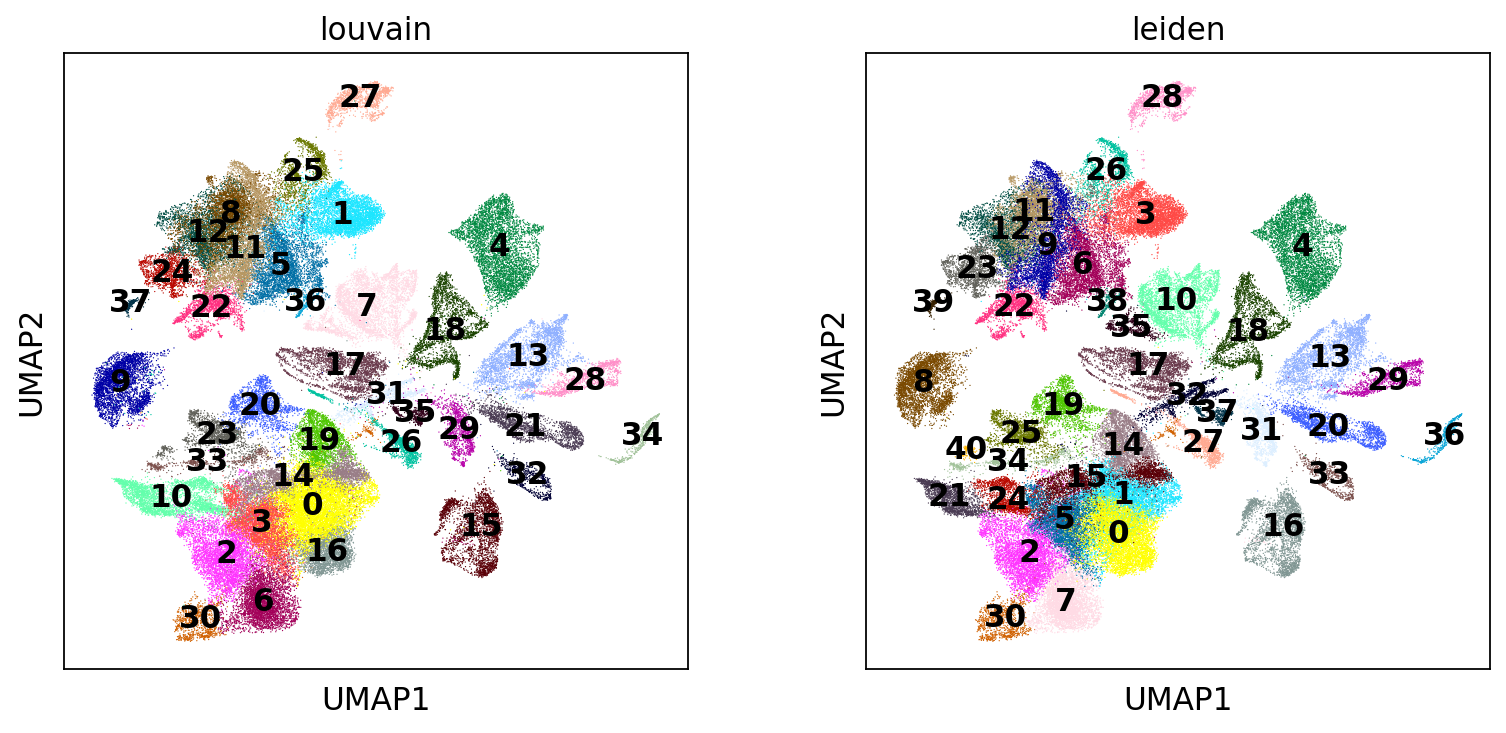

CPU times: user 625 ms, sys: 132 ms, total: 757 ms
Wall time: 598 ms


In [29]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

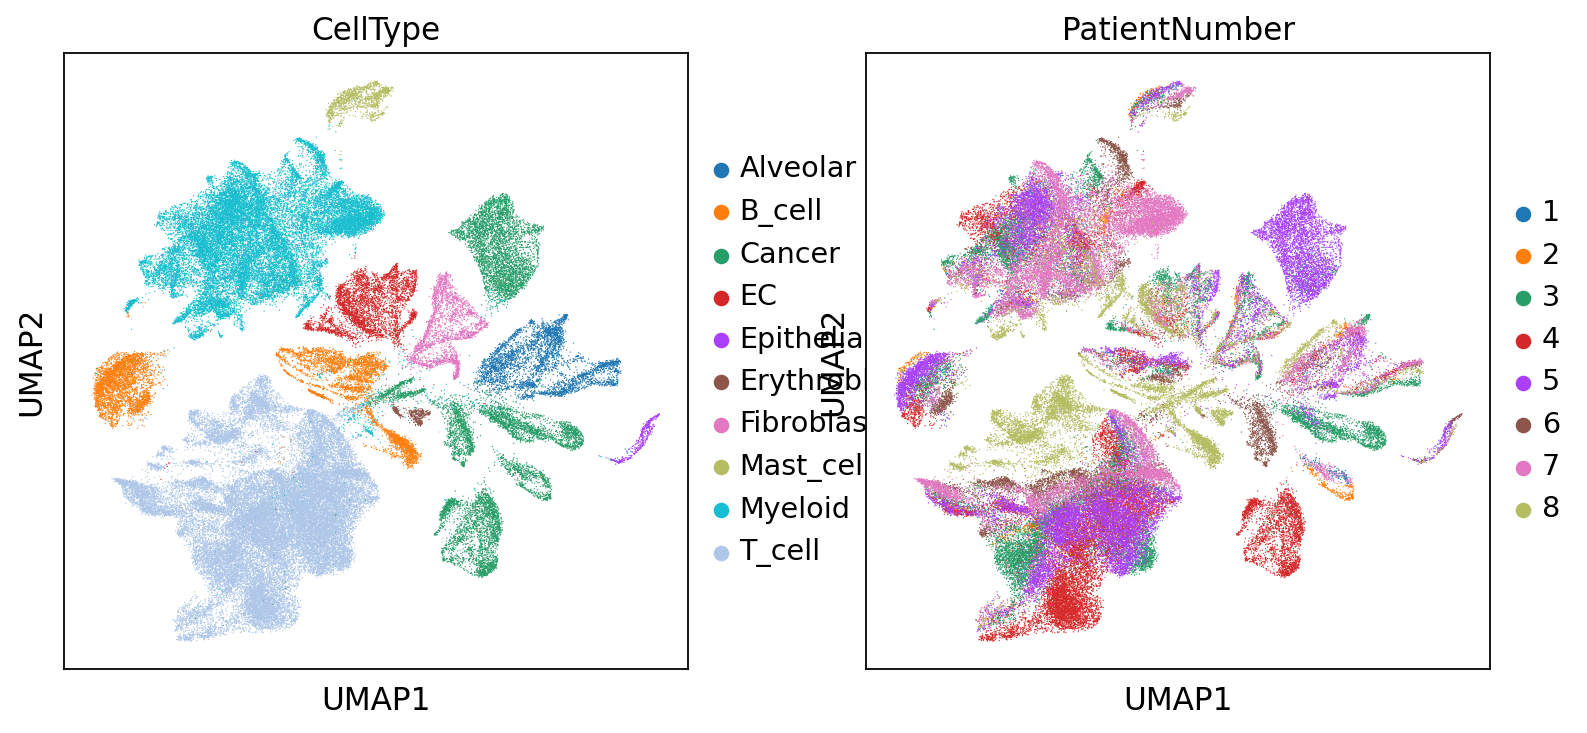

In [30]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

In [32]:
%%time
sc.tl.tsne(adata, n_pcs = 40)

/home/sdicks/miniconda3/envs/rapids-22.08/lib/python3.9/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(
/home/sdicks/miniconda3/envs/rapids-22.08/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


CPU times: user 34min 34s, sys: 20min 43s, total: 55min 18s
Wall time: 4min 2s


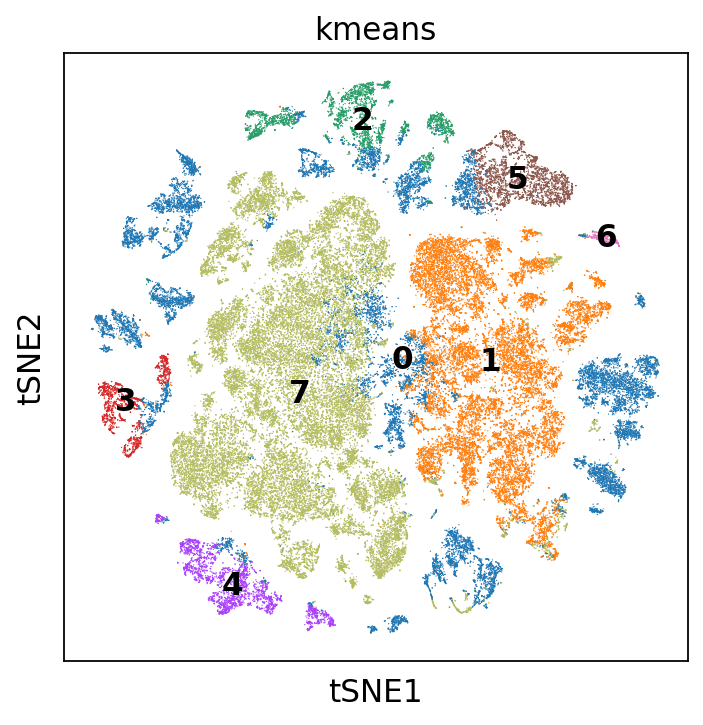

In [33]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

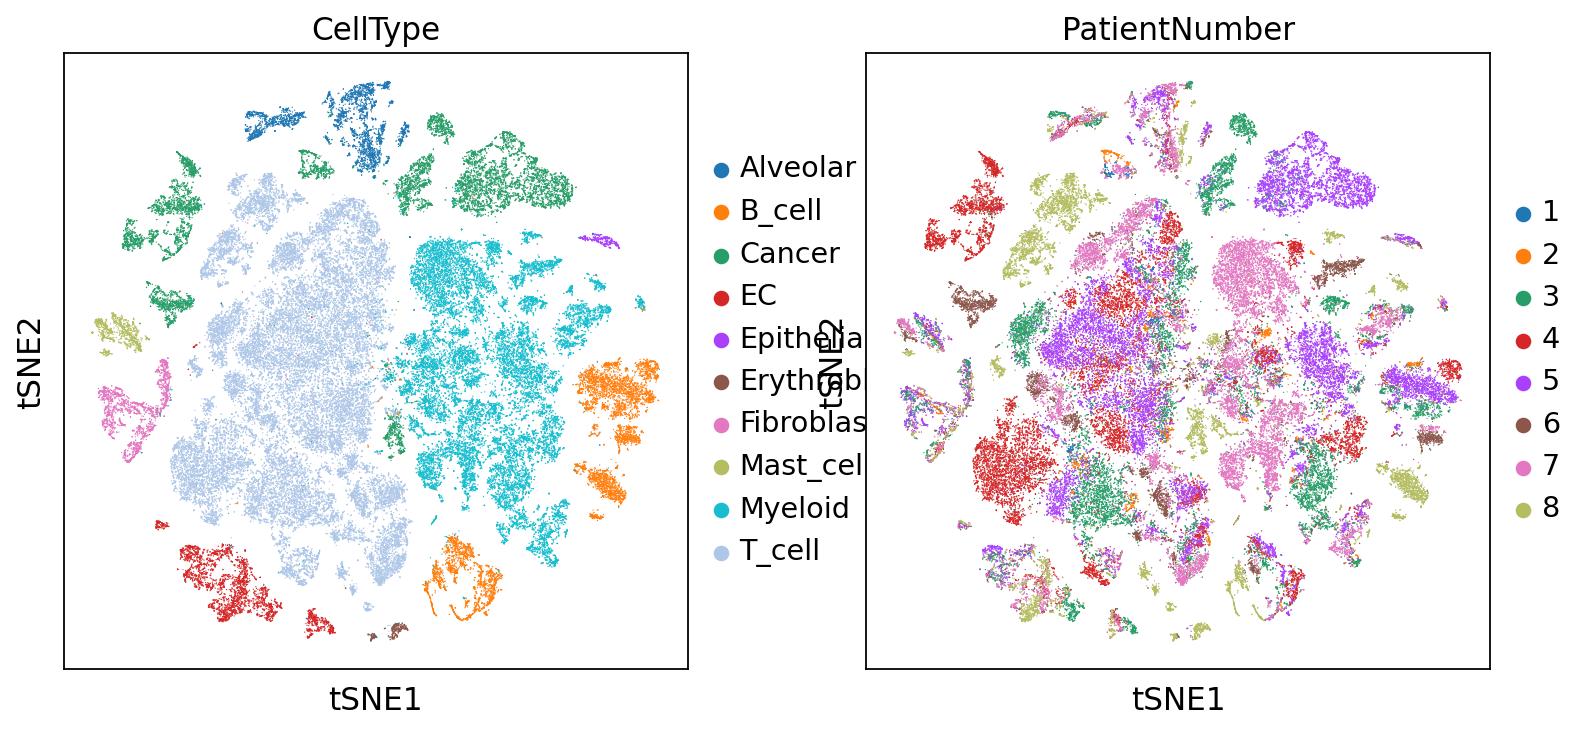

CPU times: user 743 ms, sys: 104 ms, total: 847 ms
Wall time: 688 ms


In [34]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [35]:
%%time
sc.tl.rank_genes_groups(adata, 'CellType', method='logreg', use_raw=False)

CPU times: user 35min 27s, sys: 4min 31s, total: 39min 58s
Wall time: 1min 16s


/home/sdicks/miniconda3/envs/rapids-22.08/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


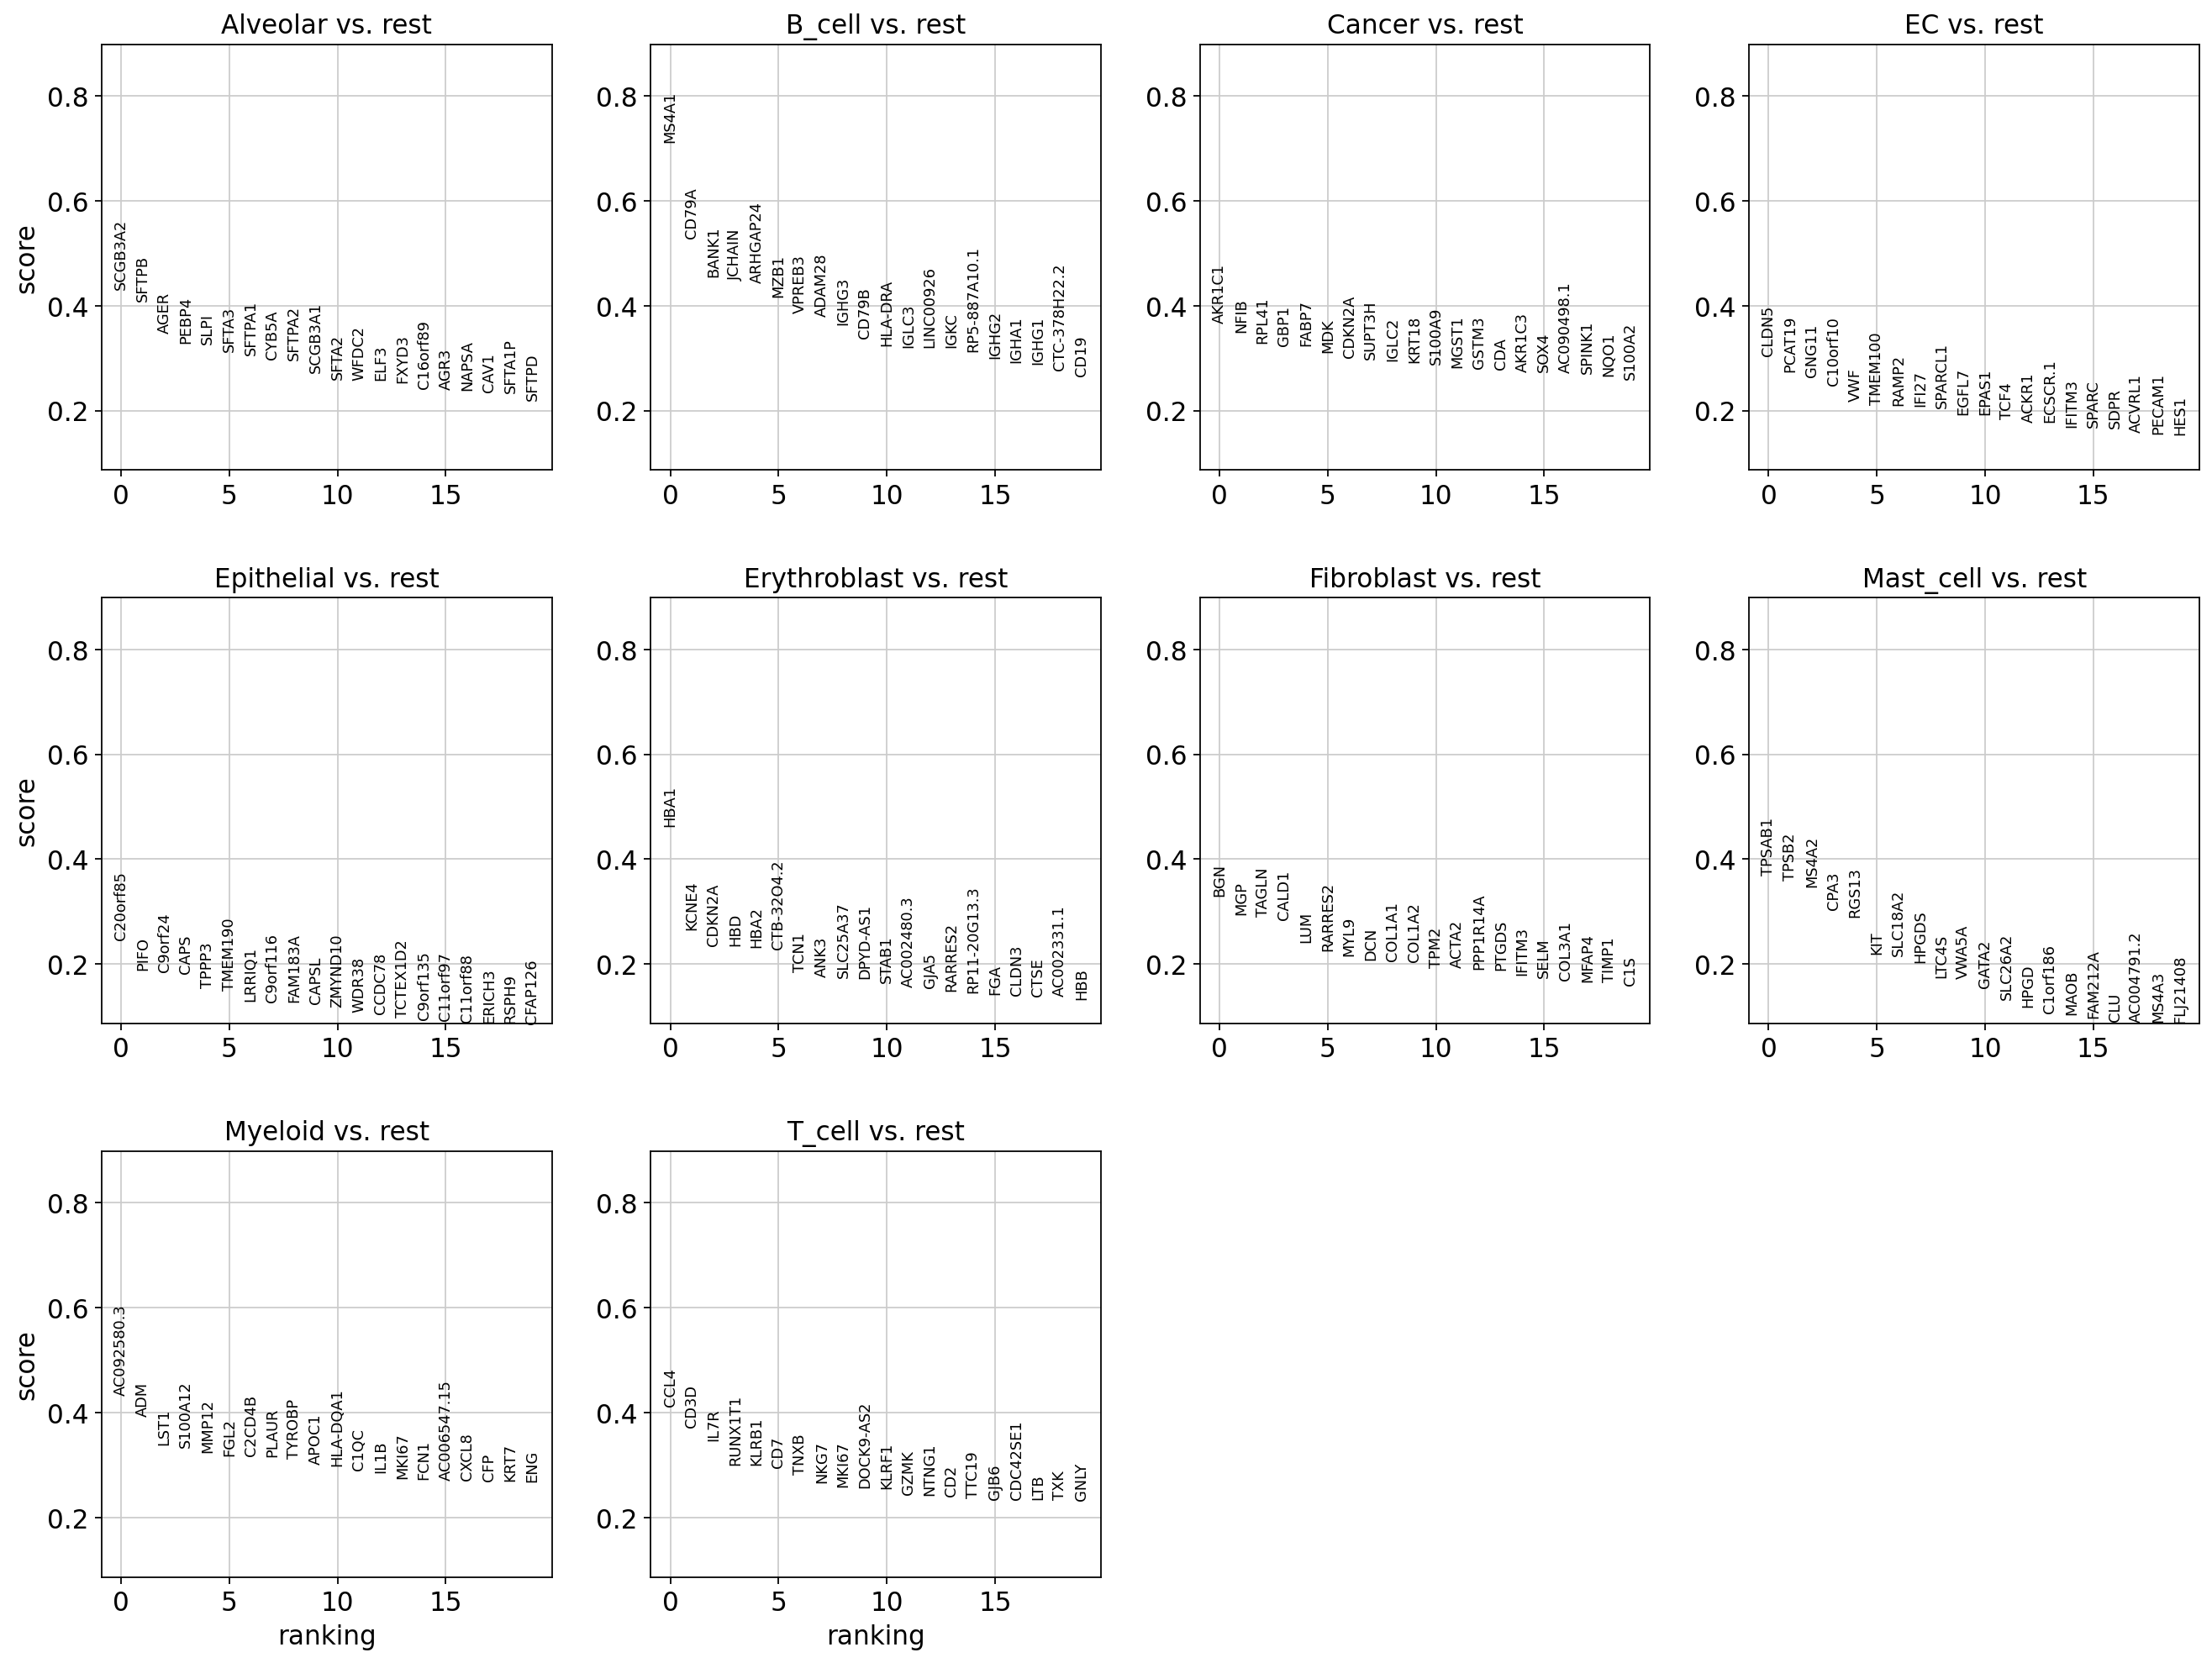

CPU times: user 1.29 s, sys: 1.3 s, total: 2.58 s
Wall time: 848 ms


In [36]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [37]:
post_time = time.time()

In [38]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 424.27105927467346


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [39]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

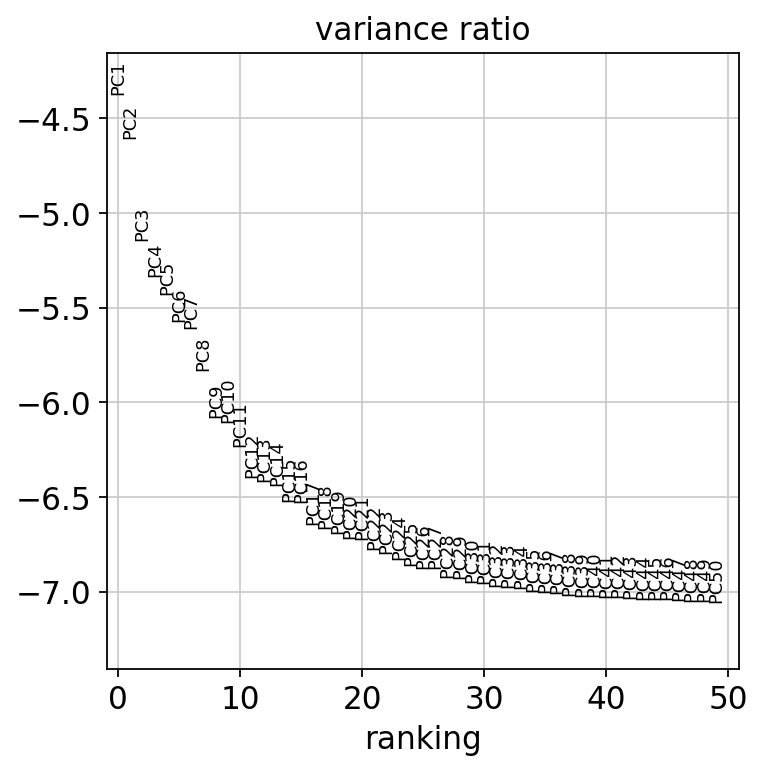

CPU times: user 5min 23s, sys: 15.7 s, total: 5min 39s
Wall time: 12.1 s


In [40]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [41]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

CPU times: user 25.4 s, sys: 10.8 s, total: 36.2 s
Wall time: 15.4 s


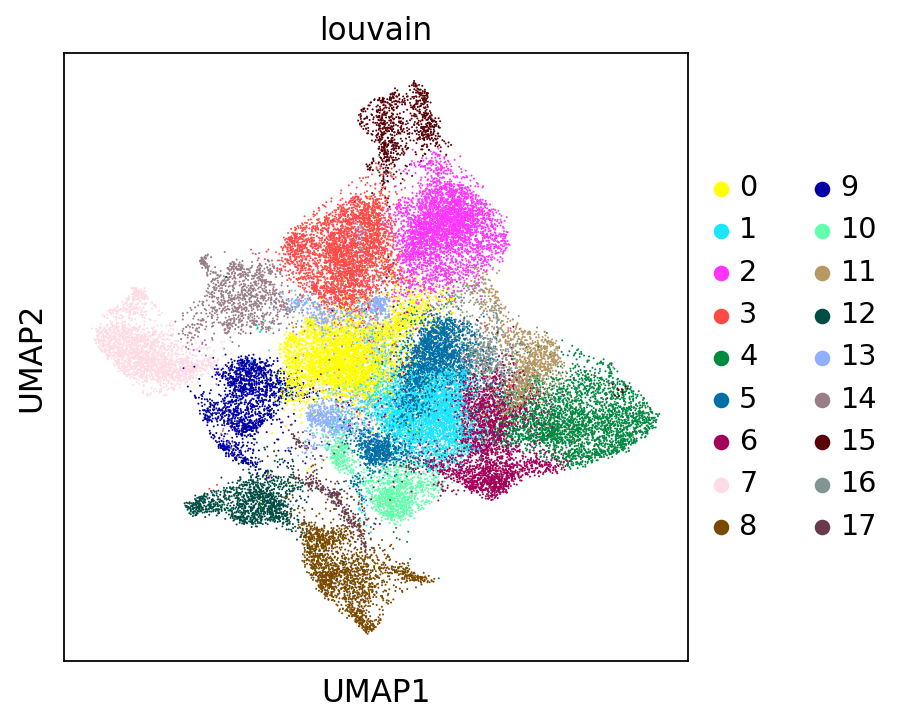

In [42]:
sc.pl.umap(tdata, color=["louvain"])

In [43]:
%%time
sc.tl.diffmap(tdata)

CPU times: user 7.09 s, sys: 14 s, total: 21.1 s
Wall time: 695 ms


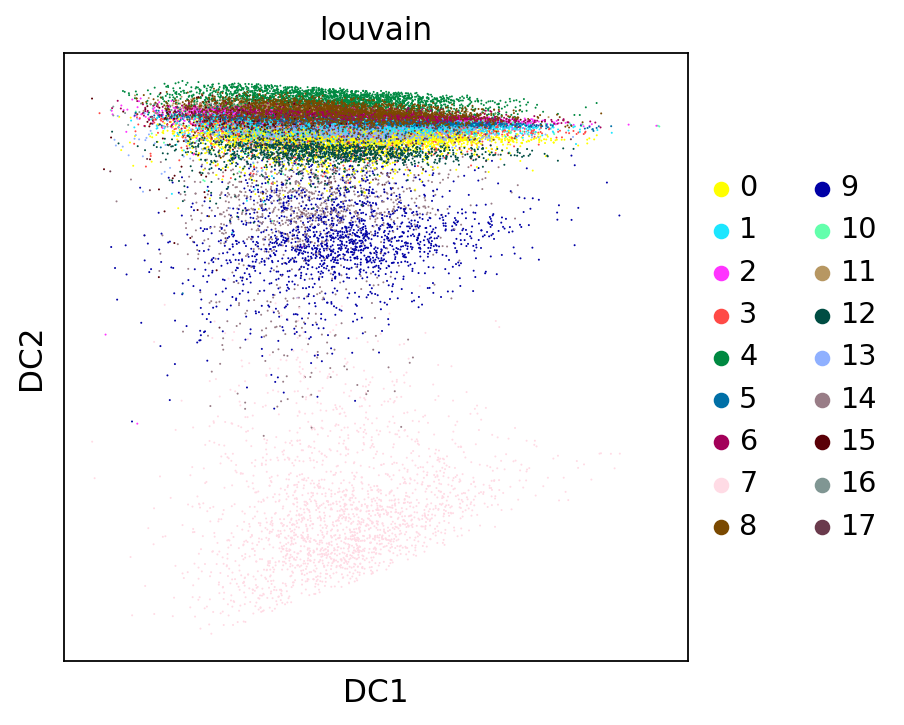

In [44]:
sc.pl.diffmap(tdata, color='louvain')

In [45]:
%%time
sc.tl.draw_graph(tdata)

CPU times: user 2min 57s, sys: 101 ms, total: 2min 57s
Wall time: 2min 57s


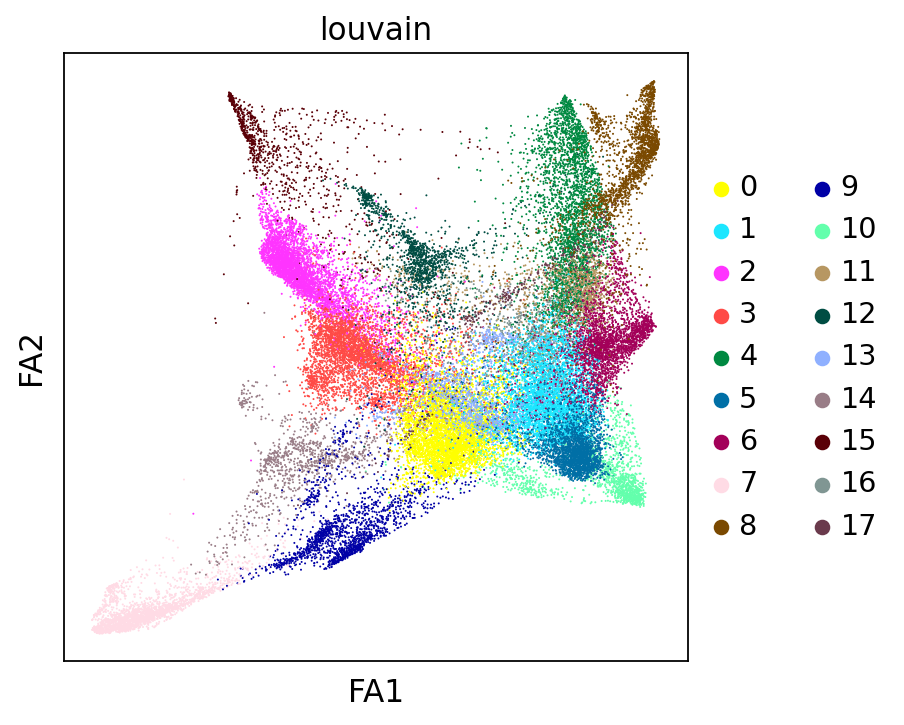

In [46]:
sc.pl.draw_graph(tdata, color='louvain')

In [47]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 695.6330108642578


## Decoupler

In [48]:
import decoupler as dc
net = dc.get_dorothea(organism='human', levels=['A','B','C'])

In [49]:
%%time
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

Running mlm on mat with 91180 samples and 25365 targets for 297 sources.


100%|███████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


CPU times: user 7min 54s, sys: 1min 59s, total: 9min 53s
Wall time: 53.2 s


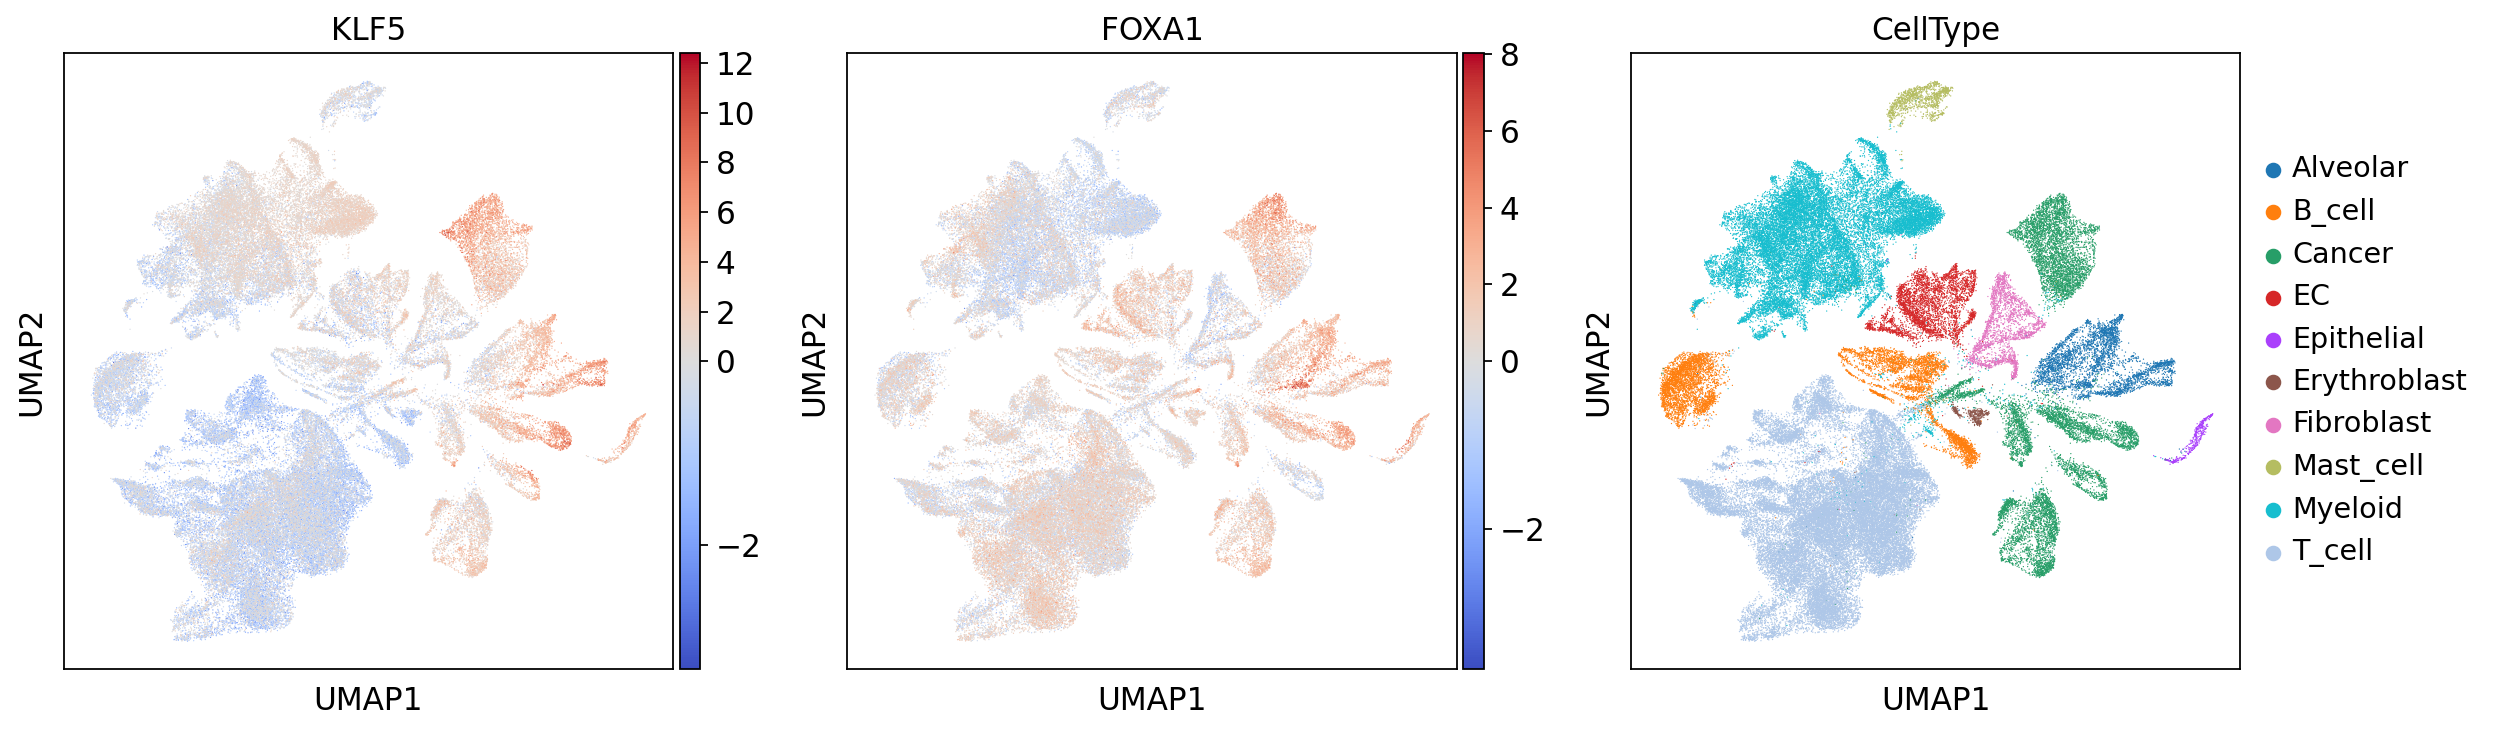

In [50]:
acts_mlm = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.umap(acts_mlm, color=['KLF5',"FOXA1", 'CellType'], cmap='coolwarm', vcenter=0)

In [51]:
model = dc.get_progeny(organism='human', top=100)

In [52]:
%%time
dc.run_wsum(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

Running wsum on mat with 91180 samples and 25365 targets for 14 sources.
Infering activities on 10 batches.


100%|███████████████████████████████████████████████████████| 10/10 [12:28<00:00, 74.85s/it]

CPU times: user 5h 21min 6s, sys: 1h 12min 57s, total: 6h 34min 3s
Wall time: 12min 29s


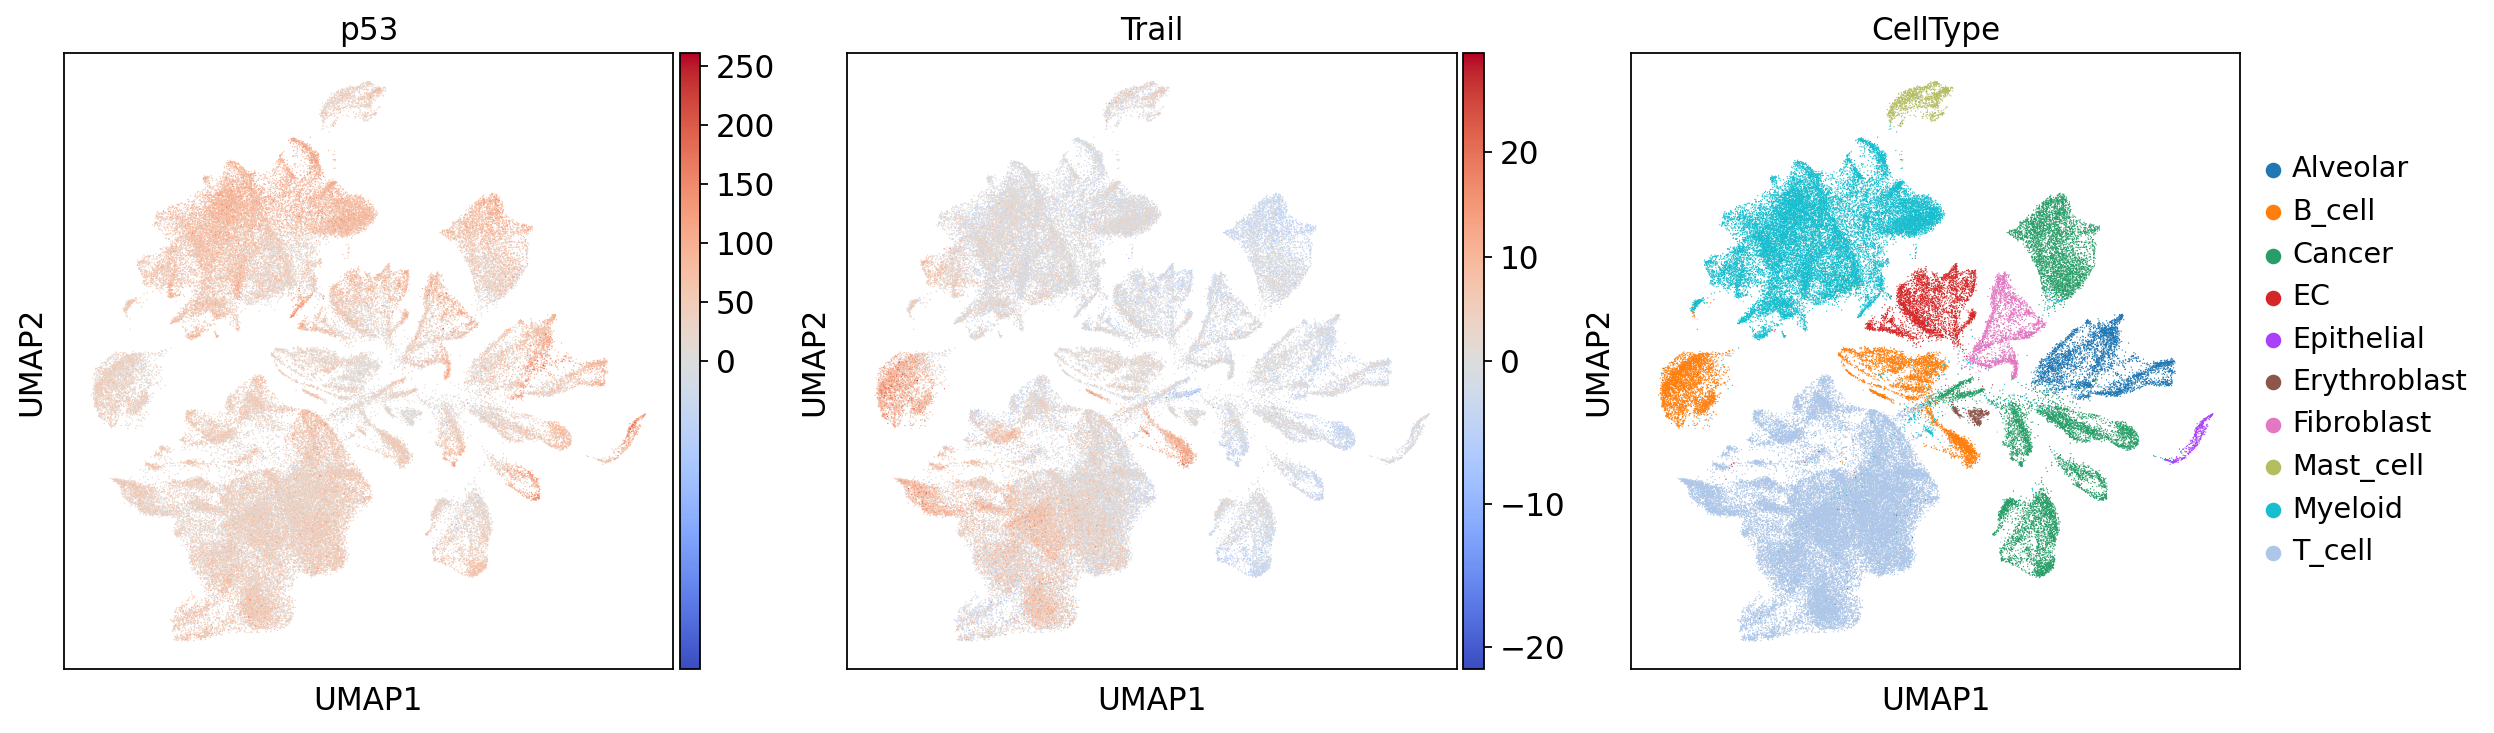

In [54]:
acts_wsum = dc.get_acts(adata, obsm_key='wsum_estimate')
sc.pl.umap(acts_wsum, color=['p53',"Trail", 'CellType'], cmap='coolwarm', vcenter=0)